In [ ]:
import pandas as pd
df = pd.read_csv('animal_df.csv')

In [ ]:
df.head(10)

,animal_type,has_name,outcome_group,age_days_outcome,age_group_intake,los_at_shelter,month_of_outcome,is_fixed,breed_type,color_group,intake_condition_group
0,Dog,0,Positive,733,Young Adult,1,February,0,Pure,Brown,Injured
1,Dog,1,Neutral,916,Young Adult,1,February,0,Mix,Black,Healthy/Normal
2,Cat,1,Positive,176,Puppy/Kitten,2,February,1,Pure,Red,Healthy/Normal
3,Other,0,Negative,732,Young Adult,1,February,0,Pure,Brown,Healthy/Normal
4,Cat,1,Positive,367,Young Adult,1,February,1,Pure,Brown,Healthy/Normal
5,Dog,1,Positive,746,Young Adult,1,February,1,Pure,Brown,Healthy/Normal
6,Dog,1,Positive,746,Young Adult,1,February,1,Pure,White,Healthy/Normal
7,Dog,1,Positive,1462,Adult,1,February,1,Mix,Black,Healthy/Normal
8,Dog,1,Positive,137,Puppy/Kitten,1,February,1,Mix,Gold,Healthy/Normal
9,Dog,0,Neutral,1465,Adult,3,February,0,Mix,Brown,Healthy/Normal


In [ ]:
df.dtypes


,0
animal_type,object
has_name,int64
outcome_group,object
age_days_outcome,int64
age_group_intake,object
los_at_shelter,int64
month_of_outcome,object
is_fixed,int64
breed_type,object
color_group,object


# Clustering

In [ ]:
# Drop target variable
df_clustering = df.drop(columns=['outcome_group'])

In [ ]:
sample_size = 30000
df_clustering_sample = df.sample(n=sample_size, random_state=42)

## K-Prototypes

No standardization of numerics or categories needed

In [ ]:
# !pip install kmodes
# !pip install ace-tools

✅ Step 1: Identifying Numerical & Categorical Features...
✅ Step 2: Finding Optimal Number of Clusters using Elbow Method...
   ▶️ Running K-Prototypes for K=2...
   ✅ Done in 136.74 sec - Cost: 8426702338.166809
   ▶️ Running K-Prototypes for K=3...
   ✅ Done in 230.35 sec - Cost: 4421115746.547457
   ▶️ Running K-Prototypes for K=4...
   ✅ Done in 303.99 sec - Cost: 2400680708.319936
   ▶️ Running K-Prototypes for K=5...
   ✅ Done in 371.15 sec - Cost: 1633944090.5030398
   ▶️ Running K-Prototypes for K=6...
   ✅ Done in 500.73 sec - Cost: 1211307544.0439186
   ▶️ Running K-Prototypes for K=7...
   ✅ Done in 569.83 sec - Cost: 923941032.2304101
   ▶️ Running K-Prototypes for K=8...
   ✅ Done in 736.86 sec - Cost: 753344030.615612
   ▶️ Running K-Prototypes for K=9...
   ✅ Done in 1070.82 sec - Cost: 689800883.4942268


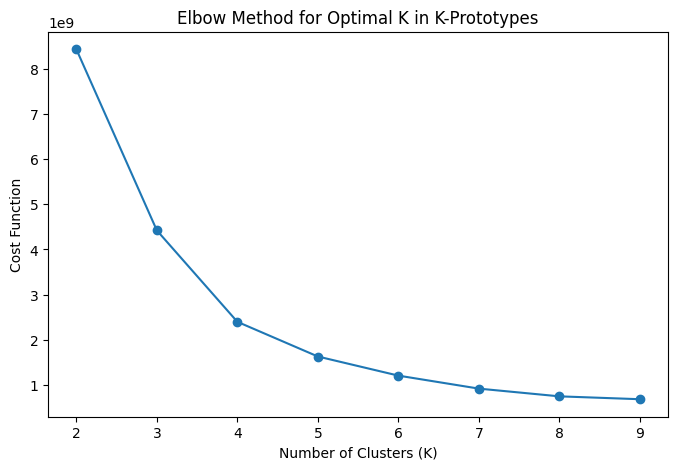

KeyboardInterrupt: Interrupted by user

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
import time


print("✅ Step 1: Identifying Numerical & Categorical Features...")
numerical_features = ['age_days_outcome', 'los_at_shelter']
categorical_features = ['animal_type', 'has_name', 'age_group_intake', 'month_of_outcome',
                        'is_fixed', 'breed_type', 'color_group', 'intake_condition_group']

# Convert categorical columns to string type
df_clustering_sample[categorical_features] = df_clustering_sample[categorical_features].astype(str)

# Convert DataFrame to numpy array for K-Prototypes
X = df_clustering_sample[numerical_features + categorical_features].to_numpy()

# Get categorical column indexes (after numerical features)
cat_cols_idx = [i for i in range(len(numerical_features), len(numerical_features + categorical_features))]

print("✅ Step 2: Finding Optimal Number of Clusters using Elbow Method...")

# Find optimal k using the Elbow Method
costs = []
K_range = range(2, 10)  # Testing cluster sizes from 2 to 10

for k in K_range:
    print(f"   ▶️ Running K-Prototypes for K={k}...")
    start_time = time.time()
    kproto = KPrototypes(n_clusters=k, random_state=42)
    kproto.fit(X, categorical=cat_cols_idx)
    costs.append(kproto.cost_)
    print(f"   ✅ Done in {round(time.time() - start_time, 2)} sec - Cost: {kproto.cost_}")

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(K_range, costs, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cost Function')
plt.title('Elbow Method for Optimal K in K-Prototypes')
plt.show()

In [ ]:
# try 4, 5, 6 clusters
# Choosing best K (Elbow point estimation)
optimal_k = 4

print(f"\n✅ Step 3: Running Final K-Prototypes with K={optimal_k}...")

# Apply K-Prototypes with optimal k
kproto = KPrototypes(n_clusters=optimal_k, random_state=42)
clusters = kproto.fit_predict(X, categorical=cat_cols_idx)

# ✅ Create a new DataFrame for storing cluster labels consistently
df_kprototypes_clusters = df_clustering_sample.copy()
df_kprototypes_clusters[f'kprototypes_cluster_{optimal_k}'] = clusters

print("✅ Clustering Completed! Here’s the cluster distribution:\n")
print(df_kprototypes_clusters[f'kprototypes_cluster_{optimal_k}'].value_counts())

# ✅ Silhouette Score Calculation
print("\n✅ Step 4: Evaluating Clusters using Silhouette Score...")
try:
    score = silhouette_score(X[:, :len(numerical_features)].astype(float), clusters)
    print(f"Silhouette Score: {score:.3f}")
except:
    print("⚠️ Silhouette Score calculation failed (common for mixed data).")

# ✅ Cluster Interpretation
print("\n✅ Step 5: Cluster Interpretation...")
cluster_summary = df_kprototypes_clusters.groupby(f'kprototypes_cluster_{optimal_k}').agg({
    'age_days_outcome': 'mean',
    'los_at_shelter': 'mean',
    'animal_type': pd.Series.mode,
    'breed_type': pd.Series.mode,
    'color_group': pd.Series.mode,
    'intake_condition_group': pd.Series.mode
}).reset_index()

from IPython.display import display
display(cluster_summary)

print(f"\n✅ Cluster assignments for K={optimal_k} stored in `df_kprototypes_clusters` 🚀")


✅ Step 3: Running Final K-Prototypes with K=4...
✅ Clustering Completed! Here’s the cluster distribution:

kprototypes_cluster_4
0    17834
2     8109
1     2715
3     1342
Name: count, dtype: int64

✅ Step 4: Evaluating Clusters using Silhouette Score...
Silhouette Score: 0.676

✅ Step 5: Cluster Interpretation...


,kprototypes_cluster_4,age_days_outcome,los_at_shelter,animal_type,breed_type,color_group,intake_condition_group
0,0,180.526466,22.035887,Cat,Mix,Black,Healthy/Normal
1,1,2292.103131,39.274033,Dog,Mix,White,Healthy/Normal
2,2,903.740412,29.304353,Dog,Mix,White,Healthy/Normal
3,3,4158.237705,42.509687,Dog,Mix,White,Healthy/Normal



✅ Cluster assignments for K=4 stored in `df_kprototypes_clusters` 🚀


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score

# Set optimal number of clusters
optimal_k = 5

print(f"\n✅ Step 1: Running Final K-Prototypes with K={optimal_k}...")

# Apply K-Prototypes with optimal k
kproto = KPrototypes(n_clusters=optimal_k, random_state=42)
clusters = kproto.fit_predict(X, categorical=cat_cols_idx)

# ✅ Ensure df_kprototypes_clusters exists & copy full dataset
if 'df_kprototypes_clusters' not in globals():
    df_kprototypes_clusters = df_clustering_sample.copy()

# ✅ Add cluster labels for K=5
df_kprototypes_clusters[f'kprototypes_cluster_{optimal_k}'] = clusters

print("✅ Clustering Completed! Here’s the cluster distribution:\n")
print(df_kprototypes_clusters[f'kprototypes_cluster_{optimal_k}'].value_counts())

# ✅ Silhouette Score Calculation
print("\n✅ Step 2: Evaluating Clusters using Silhouette Score...")
try:
    score = silhouette_score(X[:, :len(numerical_features)].astype(float), clusters)
    print(f"Silhouette Score: {score:.3f}")
except:
    print("⚠️ Silhouette Score calculation failed (common for mixed data).")

# ✅ Cluster Interpretation
print("\n✅ Step 3: Cluster Interpretation...")
cluster_summary = df_kprototypes_clusters.groupby(f'kprototypes_cluster_{optimal_k}').agg({
    'age_days_outcome': 'mean',
    'los_at_shelter': 'mean',
    'animal_type': pd.Series.mode,
    'breed_type': pd.Series.mode,
    'color_group': pd.Series.mode,
    'intake_condition_group': pd.Series.mode
}).reset_index()

from IPython.display import display
display(cluster_summary)

print(f"\n✅ Cluster assignments for K={optimal_k} stored in `df_kprototypes_clusters` 🚀")


✅ Step 1: Running Final K-Prototypes with K=5...
✅ Clustering Completed! Here’s the cluster distribution:

kprototypes_cluster_5
0    17692
2     7301
4     2518
1     1433
3     1056
Name: count, dtype: int64

✅ Step 2: Evaluating Clusters using Silhouette Score...
Silhouette Score: 0.677

✅ Step 3: Cluster Interpretation...


,kprototypes_cluster_5,age_days_outcome,los_at_shelter,animal_type,breed_type,color_group,intake_condition_group
0,0,177.798044,21.864854,Cat,Mix,Black,Healthy/Normal
1,1,2871.987439,42.759246,Dog,Mix,White,Healthy/Normal
2,2,823.450212,28.359403,Dog,Mix,White,Healthy/Normal
3,3,4375.558712,43.760417,Dog,Mix,White,Healthy/Normal
4,4,1770.291501,36.903892,Dog,Mix,White,Healthy/Normal



✅ Cluster assignments for K=5 stored in `df_kprototypes_clusters` 🚀


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from sklearn.metrics import silhouette_score
import time

# Set optimal number of clusters
optimal_k = 6

print(f"\n✅ Step 1: Running Final K-Prototypes with K={optimal_k}...")

# Apply K-Prototypes with optimal k
kproto = KPrototypes(n_clusters=optimal_k, random_state=42)
clusters = kproto.fit_predict(X, categorical=cat_cols_idx)

# ✅ Ensure df_kprototypes_clusters exists & copy full dataset
if 'df_kprototypes_clusters' not in globals():
    df_kprototypes_clusters = df_clustering_sample.copy()

# ✅ Add cluster labels for K=6
df_kprototypes_clusters[f'kprototypes_cluster_{optimal_k}'] = clusters

print("✅ Clustering Completed! Here’s the cluster distribution:\n")
print(df_kprototypes_clusters[f'kprototypes_cluster_{optimal_k}'].value_counts())

# ✅ Silhouette Score Calculation
print("\n✅ Step 2: Evaluating Clusters using Silhouette Score...")
try:
    score = silhouette_score(X[:, :len(numerical_features)].astype(float), clusters)
    print(f"Silhouette Score: {score:.3f}")
except:
    print("⚠️ Silhouette Score calculation failed (common for mixed data).")

# ✅ Cluster Interpretation
print("\n✅ Step 3: Cluster Interpretation...")
cluster_summary = df_kprototypes_clusters.groupby(f'kprototypes_cluster_{optimal_k}').agg({
    'age_days_outcome': 'mean',
    'los_at_shelter': 'mean',
    'animal_type': pd.Series.mode,
    'breed_type': pd.Series.mode,
    'color_group': pd.Series.mode,
    'intake_condition_group': pd.Series.mode
}).reset_index()

from IPython.display import display
display(cluster_summary)

print(f"\n✅ Cluster assignments for K={optimal_k} stored in `df_kprototypes_clusters` 🚀")



✅ Step 1: Running Final K-Prototypes with K=6...
✅ Clustering Completed! Here’s the cluster distribution:

kprototypes_cluster_6
0    17655
2     7141
5     2124
1     1275
4     1263
3      542
Name: count, dtype: int64

✅ Step 2: Evaluating Clusters using Silhouette Score...
Silhouette Score: 0.673

✅ Step 3: Cluster Interpretation...


,kprototypes_cluster_6,age_days_outcome,los_at_shelter,animal_type,breed_type,color_group,intake_condition_group
0,0,177.129142,21.804191,Cat,Mix,Black,Healthy/Normal
1,1,3384.801569,45.133333,Dog,Mix,White,Healthy/Normal
2,2,809.870746,27.043411,Dog,Mix,White,Healthy/Normal
3,3,4944.723247,37.972325,Dog,Mix,White,Healthy/Normal
4,4,2400.749010,39.944576,Dog,Mix,White,Healthy/Normal
5,5,1606.895009,41.265537,Dog,Mix,White,Healthy/Normal



✅ Cluster assignments for K=6 stored in `df_kprototypes_clusters` 🚀


## DBSCAN (May need Scaling) and encoding

Patterns in Intake Conditions

can help detect anomalies

Categorical needs to be encoded

if features has mixed scales then problem, if features have the same scale range standardization is not necessarry

Can try with or without standardization

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import silhouette_score
import time

print("\n✅ Step 1: Creating a New Dataset for DBSCAN Clustering...")

# Create a separate dataset for DBSCAN clustering
df_clustering_sample_dbscan = df.sample(n=30000, random_state=42).copy()

# Identify columns
numerical_features = ['age_days_outcome', 'los_at_shelter']
categorical_features = ['animal_type', 'has_name', 'age_group_intake', 'month_of_outcome',
                        'is_fixed', 'breed_type', 'color_group', 'intake_condition_group']

print("✅ Step 2: Encoding Categorical Features...")

# One-Hot Encode categorical features
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_cats = encoder.fit_transform(df_clustering_sample_dbscan[categorical_features])

print("✅ Step 3: Standardizing Numerical Features...")

# Standardize numerical features
scaler = StandardScaler()
scaled_nums = scaler.fit_transform(df_clustering_sample_dbscan[numerical_features])

# Combine encoded categorical and standardized numerical features
X_encoded = np.hstack((scaled_nums, encoded_cats))

# Choose DBSCAN parameters (These need tuning)
eps_value = 0.5  # Adjust based on data
min_samples_value = 5  # Adjust based on data

print(f"\n✅ Step 4: Running DBSCAN with eps={eps_value} and min_samples={min_samples_value}...")

# Apply DBSCAN
start_time = time.time()
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples_value)
clusters = dbscan.fit_predict(X_encoded)
print(f"   ✅ DBSCAN Completed in {round(time.time() - start_time, 2)} sec")

# Create a new DataFrame for storing cluster labels
df_dbscan_clusters = df_clustering_sample_dbscan[['age_days_outcome', 'los_at_shelter']].copy()
df_dbscan_clusters['dbscan_cluster'] = clusters

print("\n✅ Step 5: Checking Cluster Distribution...")
print(df_dbscan_clusters['dbscan_cluster'].value_counts())

# Silhouette Score Calculation (Only if more than 1 valid cluster)
unique_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

if unique_clusters > 1:
    print("\n✅ Step 6: Evaluating Clusters using Silhouette Score...")
    score = silhouette_score(X_encoded, clusters)
    print(f"Silhouette Score: {score:.3f}")
else:
    print("⚠️ Not enough clusters to compute Silhouette Score.")

# Cluster Interpretation
print("\n✅ Step 7: Cluster Interpretation...")
cluster_summary = df_clustering_sample_dbscan.groupby(clusters).agg({
    'age_days_outcome': 'mean',
    'los_at_shelter': 'mean',
    'animal_type': pd.Series.mode,
    'breed_type': pd.Series.mode,
    'color_group': pd.Series.mode,
    'intake_condition_group': pd.Series.mode
}).reset_index()

from IPython.display import display
display(cluster_summary)

print("\n✅ Cluster assignments stored in `df_dbscan_clusters` 🚀")



✅ Step 1: Creating a New Dataset for DBSCAN Clustering...
✅ Step 2: Encoding Categorical Features...
✅ Step 3: Standardizing Numerical Features...

✅ Step 4: Running DBSCAN with eps=0.5 and min_samples=5...
   ✅ DBSCAN Completed in 0.8 sec

✅ Step 5: Checking Cluster Distribution...
dbscan_cluster
-1       10294
 45        114
 100       101
 7          99
 481        97
         ...  
 1164        5
 1165        5
 1222        5
 1168        5
 1199        4
Name: count, Length: 1230, dtype: int64

✅ Step 6: Evaluating Clusters using Silhouette Score...
Silhouette Score: 0.238

✅ Step 7: Cluster Interpretation...


,index,age_days_outcome,los_at_shelter,animal_type,breed_type,color_group,intake_condition_group
0,-1,1203.527686,43.656305,Dog,Mix,Black,Healthy/Normal
1,0,129.000000,10.411765,Dog,Mix,Black,Healthy/Normal
2,1,206.611111,14.666667,Cat,Mix,White,Healthy/Normal
3,2,43.111111,13.333333,Cat,Pure,Black,Healthy/Normal
4,3,602.312500,8.562500,Dog,Mix,Brown,Healthy/Normal
...,...,...,...,...,...,...,...
1225,1224,1549.500000,8.833333,Cat,Pure,White,Healthy/Normal
1226,1225,245.200000,11.200000,Dog,Pure,Brown,Healthy/Normal
1227,1226,353.000000,66.400000,Dog,Mix,Black,Injured
1228,1227,1325.200000,10.400000,Dog,Mix,Tricolor,Healthy/Normal



✅ Cluster assignments stored in `df_dbscan_clusters` 🚀


### Checking for best eps and min samples


✅ Step 1: Estimating Best `eps` Using K-Distance Plot...


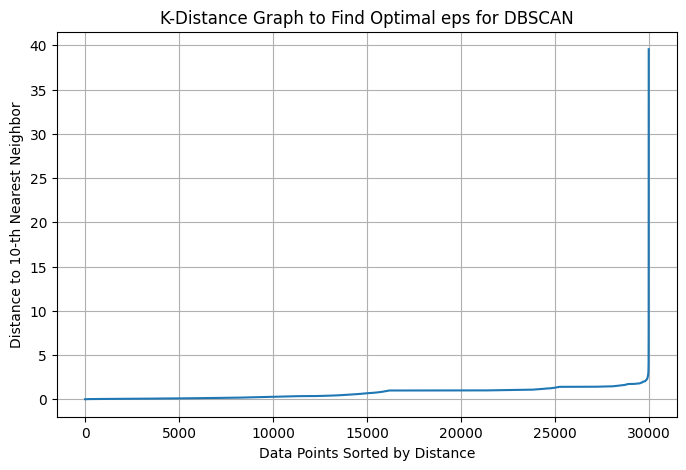

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

print("\n✅ Step 1: Estimating Best `eps` Using K-Distance Plot...")

# Compute the k-distance for nearest neighbors (default k = min_samples = 5)
min_samples_value = 10  # You can adjust this
neighbors = NearestNeighbors(n_neighbors=min_samples_value)
neighbors_fit = neighbors.fit(X_encoded)
distances, indices = neighbors_fit.kneighbors(X_encoded)

# Sort and plot k-distance
sorted_distances = np.sort(distances[:, -1])  # Get the max distance for each point
plt.figure(figsize=(8, 5))
plt.plot(sorted_distances)
plt.xlabel("Data Points Sorted by Distance")
plt.ylabel(f"Distance to {min_samples_value}-th Nearest Neighbor")
plt.title("K-Distance Graph to Find Optimal eps for DBSCAN")
plt.grid()
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
eps_value = 2.5
print("\n✅ Step 2: Testing Different DBSCAN Parameters...")

# Define a range of values for eps and min_samples
eps_range = [eps_value * 0.8, eps_value, eps_value * 1.2]  # Try slight variations
min_samples_range = [8, 10, 15]

best_score = -1
best_eps = None
best_min_samples = None

# Iterate over different values of eps and min_samples
for eps in eps_range:
    for min_samples in min_samples_range:
        print(f"   ▶️ Running DBSCAN with eps={eps:.3f}, min_samples={min_samples}...")

        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_encoded)

        # Ignore cases where most points are noise (-1 cluster)
        unique_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        if unique_clusters < 2:
            print("      ⚠️ Too few clusters, skipping...")
            continue

        # Compute Silhouette Score
        score = silhouette_score(X_encoded, clusters)
        print(f"      ✅ Silhouette Score: {score:.3f}")

        # Update best parameters
        if score > best_score:
            best_score = score
            best_eps = eps
            best_min_samples = min_samples

# Final selected parameters
if best_eps:
    print(f"\n✅ Best Parameters Found: eps={best_eps:.3f}, min_samples={best_min_samples}")
else:
    print("⚠️ No suitable parameters found. Try adjusting the eps range manually.")



✅ Step 2: Testing Different DBSCAN Parameters...
   ▶️ Running DBSCAN with eps=2.000, min_samples=8...
      ✅ Silhouette Score: 0.672
   ▶️ Running DBSCAN with eps=2.000, min_samples=10...
      ⚠️ Too few clusters, skipping...
   ▶️ Running DBSCAN with eps=2.000, min_samples=15...
      ✅ Silhouette Score: 0.663
   ▶️ Running DBSCAN with eps=2.500, min_samples=8...
      ⚠️ Too few clusters, skipping...
   ▶️ Running DBSCAN with eps=2.500, min_samples=10...
      ⚠️ Too few clusters, skipping...
   ▶️ Running DBSCAN with eps=2.500, min_samples=15...
      ⚠️ Too few clusters, skipping...
   ▶️ Running DBSCAN with eps=3.000, min_samples=8...
      ⚠️ Too few clusters, skipping...
   ▶️ Running DBSCAN with eps=3.000, min_samples=10...
      ⚠️ Too few clusters, skipping...
   ▶️ Running DBSCAN with eps=3.000, min_samples=15...
      ⚠️ Too few clusters, skipping...

✅ Best Parameters Found: eps=2.000, min_samples=8


In [ ]:
# Apply DBSCAN with optimal values
dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters = dbscan.fit_predict(X_encoded)

# ✅ Copy all features instead of only two columns
df_dbscan_clusters = df_clustering_sample_dbscan.copy()

# ✅ Add the cluster labels as a new column
df_dbscan_clusters['dbscan_cluster'] = clusters

print("\n✅ Step 4: Checking Cluster Distribution...")
print(df_dbscan_clusters['dbscan_cluster'].value_counts())

# Compute final silhouette score
if len(set(clusters)) - (1 if -1 in clusters else 0) > 1:
    score = silhouette_score(X_encoded, clusters)
    print(f"\n✅ Final Silhouette Score: {score:.3f}")
else:
    print("⚠️ Not enough clusters for Silhouette Score.")

# Cluster Interpretation
print("\n✅ Step 5: Cluster Interpretation...")
cluster_summary = df_dbscan_clusters.groupby('dbscan_cluster').agg({
    'age_days_outcome': 'mean',
    'los_at_shelter': 'mean',
    'animal_type': pd.Series.mode,
    'breed_type': pd.Series.mode,
    'color_group': pd.Series.mode,
    'intake_condition_group': pd.Series.mode
}).reset_index()

from IPython.display import display
display(cluster_summary)

print("\n✅ Cluster assignments stored in `df_dbscan_clusters` 🚀")




✅ Step 4: Checking Cluster Distribution...
dbscan_cluster
 0    29901
-1       89
 1       10
Name: count, dtype: int64

✅ Final Silhouette Score: 0.672

✅ Step 5: Cluster Interpretation...


,dbscan_cluster,age_days_outcome,los_at_shelter,animal_type,breed_type,color_group,intake_condition_group
0,-1,2668.696629,639.685393,Cat,Mix,Black,Healthy/Normal
1,0,738.171031,24.480452,Dog,Mix,White,Healthy/Normal
2,1,4178.900000,537.200000,Dog,Mix,"[Black, White]",Healthy/Normal



✅ Cluster assignments stored in `df_dbscan_clusters` 🚀


### Outlier Analysis Using Clusters

In [ ]:
# Apply DBSCAN with optimal values
best_eps = 2.0
best_min_samples = 8

print(f"\n✅ Running Final DBSCAN with eps={best_eps}, min_samples={best_min_samples}...")

dbscan = DBSCAN(eps=best_eps, min_samples=best_min_samples)
clusters = dbscan.fit_predict(X_encoded)

# Create a new DataFrame for storing cluster labels
df_dbscan_clusters = df_clustering_sample_dbscan.copy()
df_dbscan_clusters['dbscan_cluster'] = clusters

print("\n✅ Step 4: Checking Cluster Distribution...")
print(df_dbscan_clusters['dbscan_cluster'].value_counts())

# Compute final silhouette score (if valid clusters exist)
unique_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

if unique_clusters > 1:
    score = silhouette_score(X_encoded, clusters)
    print(f"\n✅ Final Silhouette Score: {score:.3f}")
else:
    print("⚠️ Not enough clusters for Silhouette Score.")



✅ Running Final DBSCAN with eps=2.0, min_samples=8...

✅ Step 4: Checking Cluster Distribution...
dbscan_cluster
 0    29901
-1       89
 1       10
Name: count, dtype: int64

✅ Final Silhouette Score: 0.672


In [ ]:
# Count the number of noise points
noise_points = (df_dbscan_clusters['dbscan_cluster'] == -1).sum()
total_points = len(df_dbscan_clusters)

print(f"\n🔍 Noise Analysis:")
print(f"   - Total Data Points: {total_points}")
print(f"   - Noise Points (-1 cluster): {noise_points}")
print(f"   - Percentage of Noise Points: {100 * noise_points / total_points:.2f}%")


🔍 Noise Analysis:
   - Total Data Points: 30000
   - Noise Points (-1 cluster): 89
   - Percentage of Noise Points: 0.30%


In [ ]:
print("\n✅ Step 5: Cluster Interpretation...")
cluster_summary = df_dbscan_clusters.groupby('dbscan_cluster').agg({
    'age_days_outcome': 'mean',
    'los_at_shelter': 'mean',
    'animal_type': pd.Series.mode,
    'breed_type': pd.Series.mode,
    'color_group': pd.Series.mode,
    'intake_condition_group': pd.Series.mode
}).reset_index()

from IPython.display import display
display(cluster_summary)

print("\n✅ Cluster assignments stored in `df_dbscan_clusters` 🚀")


✅ Step 5: Cluster Interpretation...


,dbscan_cluster,age_days_outcome,los_at_shelter,animal_type,breed_type,color_group,intake_condition_group
0,-1,2668.696629,639.685393,Cat,Mix,Black,Healthy/Normal
1,0,738.171031,24.480452,Dog,Mix,White,Healthy/Normal
2,1,4178.900000,537.200000,Dog,Mix,"[Black, White]",Healthy/Normal



✅ Cluster assignments stored in `df_dbscan_clusters` 🚀


#### Outlier Visualization


✅ Reducing Dimensionality Using PCA for Visualization...


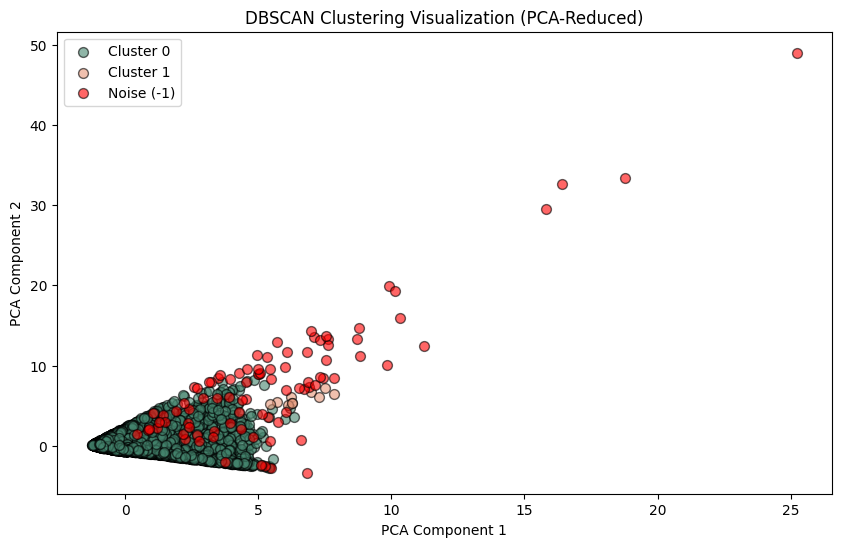

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

print("\n✅ Reducing Dimensionality Using PCA for Visualization...")

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded)

# Extract cluster labels
clusters = df_dbscan_clusters['dbscan_cluster']

# Define colors (noise points as red, clusters as different colors)
unique_clusters = set(clusters)
colors = {cluster: np.random.rand(3,) for cluster in unique_clusters}  # Assign a random color to each cluster
colors[-1] = (1, 0, 0)  # Red for noise points

# Scatter plot of PCA-reduced clusters
plt.figure(figsize=(10, 6))
for cluster in unique_clusters:
    plt.scatter(X_pca[clusters == cluster, 0], X_pca[clusters == cluster, 1],
                label=f"Cluster {cluster}" if cluster != -1 else "Noise (-1)",
                color=colors[cluster], alpha=0.6, edgecolors='k', s=50)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("DBSCAN Clustering Visualization (PCA-Reduced)")
plt.legend()
plt.show()

In [ ]:
noise_count = (df_dbscan_clusters['dbscan_cluster'] == -1).sum()
total_count = len(df_dbscan_clusters)
noise_percentage = 100 * noise_count / total_count

print(f"\n🔍 Noise Analysis:")
print(f"   - Total Data Points: {total_count}")
print(f"   - Noise Points (-1 cluster): {noise_count}")
print(f"   - Percentage of Noise Points: {noise_percentage:.2f}%")


🔍 Noise Analysis:
   - Total Data Points: 30000
   - Noise Points (-1 cluster): 89
   - Percentage of Noise Points: 0.30%


Since the outlier percentage is low we can assume that DBSCAN is clustering well

## Comparing Clusters

In [ ]:
print("\n✅ Preparing Clustering Comparisons...")

# Define clustering results to compare
clustering_methods = {
    "DBSCAN": df_dbscan_clusters["dbscan_cluster"]
}

# ✅ Dynamically add available K-Prototypes clusters
for k in [4, 5, 6]:
    column_name = f'kprototypes_cluster_{k}'
    if column_name in df_kprototypes_clusters.columns:
        clustering_methods[f"K-Prototypes K={k}"] = df_kprototypes_clusters[column_name]
    else:
        print(f"⚠️ Skipping missing column: {column_name}")

print("\n✅ Final Clustering Methods Available for Comparison:")
for method in clustering_methods.keys():
    print(f"   - {method}")


✅ Preparing Clustering Comparisons...

✅ Final Clustering Methods Available for Comparison:
   - DBSCAN
   - K-Prototypes K=4
   - K-Prototypes K=5
   - K-Prototypes K=6


### PCA Scatter Plots

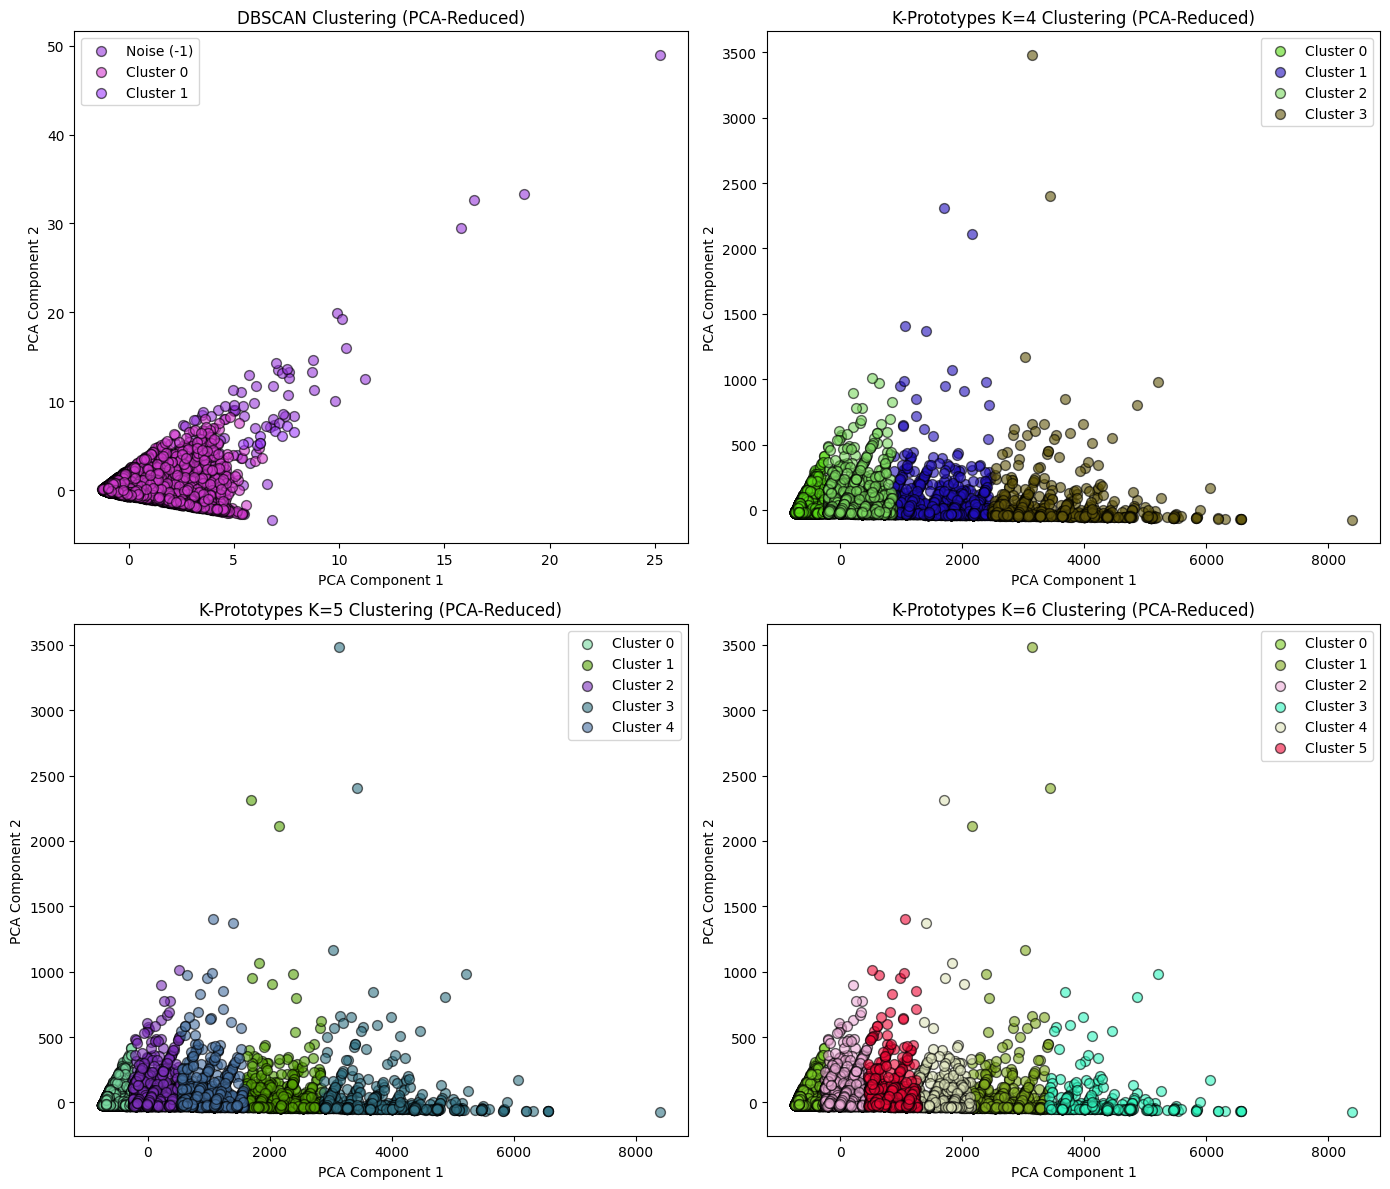

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# ✅ Apply PCA for visualization
pca = PCA(n_components=2)

# ✅ PCA for DBSCAN (uses scaled numerical features)
X_pca_dbscan = pca.fit_transform(X_encoded)

# ✅ PCA for K-Prototypes (uses raw numerical features)
X_pca_kproto = pca.fit_transform(df_kprototypes_clusters[numerical_features].to_numpy())

# ✅ Create subplots for each clustering method
fig, axes = plt.subplots(2, 2, figsize=(14, 12))  # 2 rows, 2 columns
axes = axes.flatten()

for i, (method, clusters) in enumerate(clustering_methods.items()):
    unique_clusters = np.unique(clusters)
    colors = {cluster: np.random.rand(3,) for cluster in unique_clusters}  # Assign colors

    # ✅ Use PCA-reduced dataset (DBSCAN uses scaled; K-Prototypes uses raw numerical)
    X_pca = X_pca_dbscan if "DBSCAN" in method else X_pca_kproto

    for cluster in unique_clusters:
        mask = clusters == cluster
        axes[i].scatter(X_pca[mask, 0], X_pca[mask, 1],
                        label=f"Cluster {cluster}" if cluster != -1 else "Noise (-1)",
                        color=colors[cluster], alpha=0.6, edgecolors='k', s=50)

    axes[i].set_title(f"{method} Clustering (PCA-Reduced)")
    axes[i].set_xlabel("PCA Component 1")
    axes[i].set_ylabel("PCA Component 2")
    axes[i].legend()

plt.tight_layout()
plt.show()


### Cluster Statistics

In [ ]:
print("\n✅ Comparing Clustering Statistics...")

# Create a summary table for each method
cluster_summaries = {}

for method, clusters in clustering_methods.items():
    summary = df_kprototypes_clusters.groupby(clusters).agg({
        'age_days_outcome': 'mean',
        'los_at_shelter': 'mean',
        'animal_type': pd.Series.mode,
        'breed_type': pd.Series.mode,
        'color_group': pd.Series.mode,
        'intake_condition_group': pd.Series.mode
    }).reset_index()
    cluster_summaries[method] = summary

from IPython.display import display
for method, summary in cluster_summaries.items():
    print(f"\n🔹 {method} Cluster Summary:")
    display(summary)



✅ Comparing Clustering Statistics...

🔹 DBSCAN Cluster Summary:


,dbscan_cluster,age_days_outcome,los_at_shelter,animal_type,breed_type,color_group,intake_condition_group
0,-1,2668.696629,639.685393,Cat,Mix,Black,Healthy/Normal
1,0,738.171031,24.480452,Dog,Mix,White,Healthy/Normal
2,1,4178.900000,537.200000,Dog,Mix,"[Black, White]",Healthy/Normal



🔹 K-Prototypes K=4 Cluster Summary:


,kprototypes_cluster_4,age_days_outcome,los_at_shelter,animal_type,breed_type,color_group,intake_condition_group
0,0,180.526466,22.035887,Cat,Mix,Black,Healthy/Normal
1,1,2292.103131,39.274033,Dog,Mix,White,Healthy/Normal
2,2,903.740412,29.304353,Dog,Mix,White,Healthy/Normal
3,3,4158.237705,42.509687,Dog,Mix,White,Healthy/Normal



🔹 K-Prototypes K=5 Cluster Summary:


,kprototypes_cluster_5,age_days_outcome,los_at_shelter,animal_type,breed_type,color_group,intake_condition_group
0,0,177.798044,21.864854,Cat,Mix,Black,Healthy/Normal
1,1,2871.987439,42.759246,Dog,Mix,White,Healthy/Normal
2,2,823.450212,28.359403,Dog,Mix,White,Healthy/Normal
3,3,4375.558712,43.760417,Dog,Mix,White,Healthy/Normal
4,4,1770.291501,36.903892,Dog,Mix,White,Healthy/Normal



🔹 K-Prototypes K=6 Cluster Summary:


,kprototypes_cluster_6,age_days_outcome,los_at_shelter,animal_type,breed_type,color_group,intake_condition_group
0,0,177.129142,21.804191,Cat,Mix,Black,Healthy/Normal
1,1,3384.801569,45.133333,Dog,Mix,White,Healthy/Normal
2,2,809.870746,27.043411,Dog,Mix,White,Healthy/Normal
3,3,4944.723247,37.972325,Dog,Mix,White,Healthy/Normal
4,4,2400.749010,39.944576,Dog,Mix,White,Healthy/Normal
5,5,1606.895009,41.265537,Dog,Mix,White,Healthy/Normal


### Silhouette Comparison

In [ ]:
from sklearn.metrics import silhouette_score

print("\n✅ Evaluating Clustering Quality with Silhouette Scores...")

silhouette_scores = {}

for method, clusters in clustering_methods.items():
    # ✅ Use **scaled numerical features** only for DBSCAN, unscaled for K-Prototypes
    X_silhouette = X_encoded if "DBSCAN" in method else df_kprototypes_clusters[numerical_features].to_numpy()

    # Compute silhouette score only if there are at least 2 clusters
    unique_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)

    if unique_clusters > 1:
        score = silhouette_score(X_silhouette, clusters)
        silhouette_scores[method] = score
        print(f"   🔹 {method} Silhouette Score: {score:.3f}")
    else:
        print(f"   ⚠️ {method} has too few clusters for silhouette evaluation.")

# Identify the best clustering method
best_method = max(silhouette_scores, key=silhouette_scores.get)
print(f"\n✅ Best Clustering Method Based on Silhouette Score: {best_method}")



✅ Evaluating Clustering Quality with Silhouette Scores...
   🔹 DBSCAN Silhouette Score: 0.672
   🔹 K-Prototypes K=4 Silhouette Score: 0.676
   🔹 K-Prototypes K=5 Silhouette Score: 0.677
   🔹 K-Prototypes K=6 Silhouette Score: 0.673

✅ Best Clustering Method Based on Silhouette Score: K-Prototypes K=5


#### Save Files

In [ ]:
# ✅ Save K-Prototypes clusters
df_kprototypes_clusters.to_csv("kprototypes_clusters.csv", index=False)
print("✅ K-Prototypes cluster labels saved to 'kprototypes_clusters.csv'.")

# ✅ Save DBSCAN clusters
df_dbscan_clusters.to_csv("dbscan_clusters.csv", index=False)
print("✅ DBSCAN cluster labels saved to 'dbscan_clusters.csv'.")

✅ K-Prototypes cluster labels saved to 'kprototypes_clusters.csv'.
✅ DBSCAN cluster labels saved to 'dbscan_clusters.csv'.
